In [1]:
import os.path

from sklearn.cluster import DBSCAN
from matplotlib.patches import Rectangle
from PIL import Image
import numpy as np
import cv2
import yolo_detection as yd
import picture_roi as pr
import dbscan_line as dl
import matplotlib.pyplot as plt

image_path = r"C:\Users\rainbow_yu\Desktop\p1.png"
image = pr.extract_roi(image_path)
image, mask , detections = yd.detect_objects(image, yd.load_model("train_class"))
image, _, _ = dl.create_line(image, mask)
plt.imshow(image)
plt.axis('off')
plt.show()
# detections = yd.remove_low_confidence_detections(detections, 0.1)
print(detections)



0: 352x640 1 Mobile-Phone, 94.8ms
Speed: 11.5ms preprocess, 94.8ms inference, 404.8ms postprocess per image at shape (1, 3, 352, 640)


IndexError: list index out of range

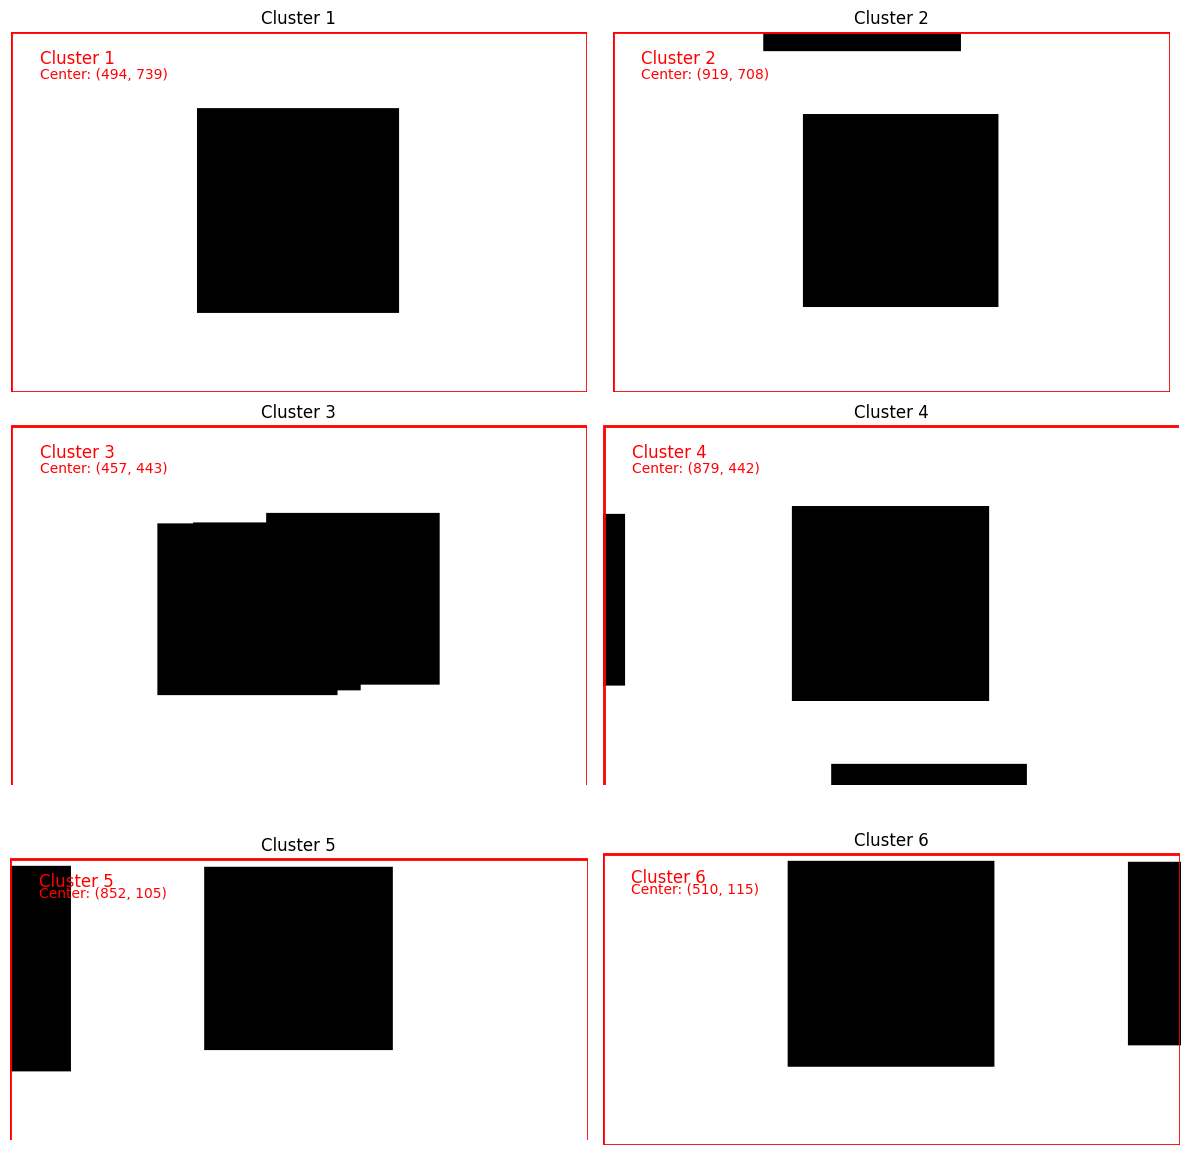

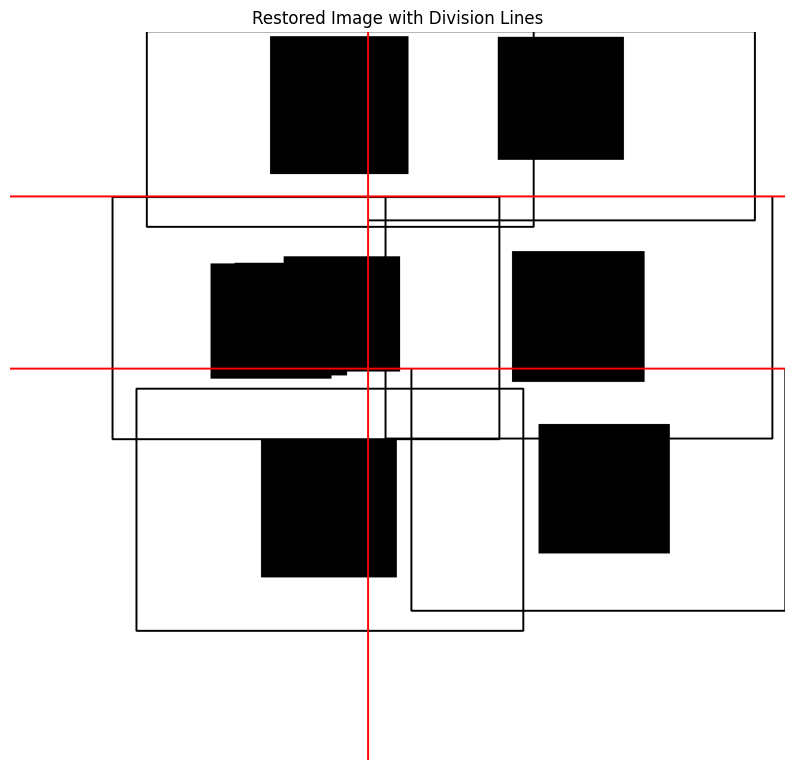

In [10]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# 读取图像并转换为灰度
image = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# 二值化（将图像转为黑白）
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

# 执行膨胀操作以扩大连通区域
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))  # 核大小越大，扩展范围越大
dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

# 去除小噪点：使用开运算（先腐蚀后膨胀）来去除小的连通区域
kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))  # 可调整核的大小
opened_image = cv2.morphologyEx(dilated_image, cv2.MORPH_OPEN, kernel_open)

# 查找连通域
contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 获取连通域的中心坐标
centroids = []
for contour in contours:
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append([cX, cY])

# 使用 DBSCAN 聚类算法进行聚类
eps = 150  # 邻域半径
min_samples = 1  # 每个聚类中的最小样本数
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(centroids)

# 获取图像的尺寸
height, width = image.shape

# 获取聚类结果
unique_labels = np.unique(labels)

# 排除噪声点标签为-1
centroids_no_noise = [centroids[i] for i in range(len(centroids)) if labels[i] != -1]
labels_no_noise = labels[labels != -1]

# 根据聚类位置计算行列数
x_coords = [centroid[0] for centroid in centroids_no_noise]
y_coords = [centroid[1] for centroid in centroids_no_noise]

# 计算位置范围
min_x, max_x = min(x_coords), max(x_coords)
min_y, max_y = min(y_coords), max(y_coords)

# 根据位置范围计算行列数
row = int(np.ceil(np.sqrt(len(centroids_no_noise))))
col = int(np.ceil(len(centroids_no_noise) / row))

# 创建子图
fig, axes = plt.subplots(row, col, figsize=(12, 12))
axes = axes.flatten()  # 将axes展平成一维，便于索引

# 创建一张新的图像，用于显示聚类区域
restored_image = image.copy()

# 遍历每个子图
for idx, ax in enumerate(axes):
    ax.set_title(f'Cluster {idx + 1}')
    ax.axis('off')

    # 检查当前索引是否有对应的聚类
    if idx < len(centroids_no_noise):
        cX, cY = centroids_no_noise[idx]

        # 计算子图区域的边界，给定中心和一些大小
        sub_width = width // col
        sub_height = height // row

        # 计算聚类边界（基于中心点的偏移）
        start_y = max(0, cY - sub_height // 2)
        end_y = min(height, cY + sub_height // 2)
        start_x = max(0, cX - sub_width // 2)
        end_x = min(width, cX + sub_width // 2)

        # 切割原始图像的对应部分
        sub_image = image[start_y:end_y, start_x:end_x]

        # 显示切割的子图
        ax.imshow(sub_image, cmap='gray')

        # 在子图外面画一个矩形框，框住该区域
        rect = Rectangle((0, 0), end_x - start_x, end_y - start_y, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # 绘制聚类信息：显示聚类编号和中心坐标
        ax.text(0.05, 0.95, f'Cluster {idx + 1}', transform=ax.transAxes, color='red', fontsize=12, ha='left', va='top')
        ax.text(0.05, 0.90, f'Center: ({cX}, {cY})', transform=ax.transAxes, color='red', fontsize=10, ha='left', va='top')

        # 在原图上绘制矩形框，标出当前子图区域
        cv2.rectangle(restored_image, (start_x, start_y), (end_x, end_y), (0, 0, 0), 2)
    else:
        ax.axis('off')  # 如果当前子图没有对应聚类，则关闭

# 调整布局并显示
plt.tight_layout()
plt.show()

# 在原图上绘制分割线
restored_image_with_lines = restored_image.copy()

# 初始化分割线列表
vertical_lines = []
horizontal_lines = []

# 计算每个子图的边界（基于中心点位置）
sub_rects = []
for cX, cY in centroids_no_noise:
    sub_width = width // col
    sub_height = height // row

    start_y = max(0, cY - sub_height // 2)
    end_y = min(height, cY + sub_height // 2)
    start_x = max(0, cX - sub_width // 2)
    end_x = min(width, cX + sub_width // 2)
    
    sub_rects.append((start_x, start_y, end_x, end_y))

# 遍历所有子图，记录行列交界处的分割线
for i in range(1, len(sub_rects)):
    prev_x, prev_y, prev_end_x, prev_end_y = sub_rects[i - 1]
    curr_x, curr_y, curr_end_x, curr_end_y = sub_rects[i]

    # 记录垂直分割线
    if prev_x != curr_x:
        vertical_lines.append(curr_x)

    # 记录水平分割线
    if prev_y != curr_y:
        horizontal_lines.append(curr_y)

# 定义横向和纵向去重的阈值
horizontal_threshold = width // col // 3
vertical_threshold = height // row // 3

# 去重函数
def deduplicate_lines(lines, threshold):
    lines = sorted(lines)  # 先排序
    deduplicated = [lines[0]]  # 保留第一条线
    for line in lines[1:]:
        if line - deduplicated[-1] >= threshold:  # 与上一次保留的线比较
            deduplicated.append(line)
    return deduplicated

# 去重后的分割线
vertical_lines = deduplicate_lines(vertical_lines, vertical_threshold)
horizontal_lines = deduplicate_lines(horizontal_lines, horizontal_threshold)

# 确保分割线两侧存在聚类中心点的函数
def validate_lines(lines, centroids, axis, max_size):
    validated_lines = []
    for line in lines:
        # 左侧和右侧的边界范围
        lower_bound = line
        upper_bound = line
        
        # 检查是否存在聚类中心点
        has_left = any(c[axis] < lower_bound for c in centroids)
        has_right = any(c[axis] >= upper_bound for c in centroids)
        
        if has_left and has_right:
            validated_lines.append(line)
    return validated_lines

# 验证并去除无效分割线
vertical_lines = validate_lines(vertical_lines, centroids_no_noise, axis=0, max_size=width)
horizontal_lines = validate_lines(horizontal_lines, centroids_no_noise, axis=1, max_size=height)

restored_image_with_lines = cv2.cvtColor(restored_image_with_lines, cv2.COLOR_GRAY2BGR)

# 绘制分割线
for x in vertical_lines:
    cv2.line(restored_image_with_lines, (x, 0), (x, height), (255, 0, 0), 2)

for y in horizontal_lines:
    cv2.line(restored_image_with_lines, (0, y), (width, y), (255, 0, 0), 2)


# 显示绘制分割线后的图像
plt.figure(figsize=(10, 10))
plt.imshow(restored_image_with_lines, cmap='gray')
plt.title("Restored Image with Division Lines")
plt.axis('off')
plt.show()


In [11]:
def class_name_and_center(detections, image):
    """
    将每个 detection 的中心点 (x, y) 坐标归一化后，与对应的类别名称配对。
    
    参数:
        detections: list，每个元素包含检测结果，格式如 
                    (array([x_min, y_min, x_max, y_max], dtype=float32), ..., {'class_name': '...'})
        image: 图像数据，用于获取宽度和高度信息 (image.shape)
    
    返回:
        list: 包含 (class_name, x_center, y_center) 的元组列表
    """
    # 提取图像高度和宽度
    height, width, _ = image.shape

    # 提取 class_name 和对应的中心点
    class_centers = [
        (
            detection[-1]['class_name'],  # 类别名称
            (detection[0][0] + detection[0][2]) / 2,  # x_center 归一化
            (detection[0][1] + detection[0][3]) / 2  # y_center 归一化
        )
        for detection in detections
    ]
    
    return class_centers

In [90]:
def organize_detections(class_centers, row_lines, col_lines):
    """
    将检测结果根据中心点在分割线的位置划分到行列矩阵中。

    参数:
        class_centers: list，每个元素为 (class_name, x_center, y_center) 的元组
        row_lines: list，表示行分割线的 y 坐标，从小到大排列
        col_lines: list，表示列分割线的 x 坐标，从小到大排列

    返回:
        matrix: list，row+1 行，col+1 列的二维列表，每个元素包含该单元格内的 class_name
    """
    # 检查输入的分割线是否有序
    if row_lines != sorted(row_lines):
        raise ValueError("Row lines must be sorted in ascending order.")
    if col_lines != sorted(col_lines):
        raise ValueError("Column lines must be sorted in ascending order.")
    
    # 对 class_centers 按 x_center 排序
    class_centers_sorted = sorted(class_centers, key=lambda x: x[1])  # 根据 x_center 排序

    # 初始化矩阵
    num_rows = len(row_lines) + 1
    num_cols = len(col_lines) + 1
    matrix = [['' for _ in range(num_cols)] for _ in range(num_rows)]  # 改为存储字符串

    # 确定中心点所在行号
    def get_row_idx(y_center):
        return next((i for i, y in enumerate(row_lines) if y_center < y), len(row_lines))

    # 确定中心点所在列号
    def get_col_idx(x_center):
        return next((i for i, x in enumerate(col_lines) if x_center < x), len(col_lines))

    # 遍历排序后的检测结果，填充矩阵
    for class_name, x_center, y_center in class_centers_sorted:
        row_idx = get_row_idx(y_center)
        col_idx = get_col_idx(x_center)
        if class_name == "[" or class_name == "]":
            continue
        if class_name == "-" and matrix[row_idx][col_idx]:  # 如果该格已经有值
            continue
        # 如果当前格子有元素且是'-'，将当前元素合并到已有的元素
        if matrix[row_idx][col_idx]:
            matrix[row_idx][col_idx] += class_name
        else:
            matrix[row_idx][col_idx] = class_name
    
    for r in range(len(matrix)):
        for c in range(len(matrix[r_idx])):
            matrix[r][c] = int(matrix[r][c])
    
    return matrix


# 示例调用
matrix = organize_detections(class_name_and_center(detections, mask), horizontal_lines, vertical_lines)

# 打印结果
for r_idx, row in enumerate(matrix):
    for c_idx, cell in enumerate(row):
        print(f"Row {r_idx}, Col {c_idx}: {cell}")

print(matrix)

Row 0, Col 0: -18
Row 0, Col 1: 23
Row 0, Col 2: 397
Row 1, Col 0: 42
Row 1, Col 1: 96
Row 1, Col 2: 87
Row 2, Col 0: 33
Row 2, Col 1: 15
Row 2, Col 2: -54
[[-18, 23, 397], [42, 96, 87], [33, 15, -54]]


In [2]:
from manim import *

Manim Community v0.18.0

In [8]:
matrix = r"""
    \left[\begin{array}
    1 & 2 & 3 \\
    4 & 5 & 6 \\
    7 & 8 & 9
    \end{array}\right]
    """

fig, ax = plt.subplots()
ax.axis('off')  # 关闭坐标轴
ax.text(0.5, 0.5, r"$%s$" % matrix, fontsize=20, ha='center', va='center')  # 使用 MathText 渲染

plt.show()

RuntimeError: latex was not able to process the following string:
b'$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpq28phshe 12460b452c85b4813cae90f8d4bfd330.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.10) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(12460b452c85b4813cae90f8d4bfd330.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-09-28> (E:\miktex\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(E:\miktex\tex/latex/base\size10.clo)) (E:\miktex\tex/latex/type1cm\type1cm.sty
) (E:\miktex\tex/latex/cm-super\type1ec.sty (E:\miktex\tex/latex/base\t1cmr.fd)
) (E:\miktex\tex/latex/base\inputenc.sty)
(E:\miktex\tex/latex/geometry\geometry.sty
(E:\miktex\tex/latex/graphics\keyval.sty)
(E:\miktex\tex/generic/iftex\ifvtex.sty (E:\miktex\tex/generic/iftex\iftex.sty)
) (E:\miktex\tex/latex/geometry\geometry.cfg))
(E:\miktex\tex/latex/underscore\underscore.sty)
(E:\miktex\tex/latex/base\textcomp.sty)
(E:\miktex\tex/latex/l3backend\l3backend-dvips.def)
No file 12460b452c85b4813cae90f8d4bfd330.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Extra }, or forgotten $.
<recently read> }
                 
l.29 {\rmfamily $}
                  %
No pages of output.
Transcript written on C:\Users\rainbow_yu\.matplotlib\tex.cache\12\46\tmpq28phs
he\12460b452c85b4813cae90f8d4bfd330.log.




<Figure size 640x480 with 1 Axes>

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 启用 LaTeX 模式
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# 创建两个矩阵
matrix1 = np.random.randint(0, 10, (3, 3))
matrix2 = np.random.randint(0, 10, (3, 3))
matrix_sum = matrix1 + matrix2

# 将矩阵转换为 LaTeX 格式字符串
def matrix_to_latex(matrix):
    rows = [" & ".join(map(str, row)) for row in matrix]
    return r"\begin{bmatrix}" + " \\\\ ".join(rows) + r"\end{bmatrix}"

# 生成 LaTeX 表达式
latex_expr = (
    f"${matrix_to_latex(matrix1)} + {matrix_to_latex(matrix2)} = {matrix_to_latex(matrix_sum)}$"
)

# 绘制图像并展示 LaTeX 表达式
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis("off")  # 隐藏坐标轴
ax.text(0.5, 0.5, latex_expr, fontsize=18, ha="center", va="center")

# 显示图像
plt.tight_layout()
plt.show()


RuntimeError: latex was not able to process the following string:
b'$\\\\begin{bmatrix}8 & 4 & 8 \\\\\\\\ 9 & 1 & 3 \\\\\\\\ 4 & 1 & 2\\\\end{bmatrix} + \\\\begin{bmatrix}6 & 8 & 7 \\\\\\\\ 1 & 1 & 7 \\\\\\\\ 9 & 4 & 4\\\\end{bmatrix} = \\\\begin{bmatrix}14 & 12 & 15 \\\\\\\\ 10 & 2 & 10 \\\\\\\\ 13 & 5 & 6\\\\end{bmatrix}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpkph0bsgq 07c9b191fe746fb2ec23e2df520508d2.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.10) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(07c9b191fe746fb2ec23e2df520508d2.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-09-28> (E:\miktex\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(E:\miktex\tex/latex/base\size10.clo)) (E:\miktex\tex/latex/type1cm\type1cm.sty
) (E:\miktex\tex/latex/cm-super\type1ec.sty (E:\miktex\tex/latex/base\t1cmr.fd)
) (E:\miktex\tex/latex/base\inputenc.sty)
(E:\miktex\tex/latex/geometry\geometry.sty
(E:\miktex\tex/latex/graphics\keyval.sty)
(E:\miktex\tex/generic/iftex\ifvtex.sty (E:\miktex\tex/generic/iftex\iftex.sty)
) (E:\miktex\tex/latex/geometry\geometry.cfg))
(E:\miktex\tex/latex/underscore\underscore.sty)
(E:\miktex\tex/latex/base\textcomp.sty)
(E:\miktex\tex/latex/l3backend\l3backend-dvips.def)
No file 07c9b191fe746fb2ec23e2df520508d2.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Environment bmatrix undefined.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\rmfamily $\begin{bmatrix}
                                8 & 4 & 8 \\ 9 & 1 & 3 \\ 4 & 1 & 2\end{bmat...
No pages of output.
Transcript written on C:\Users\rainbow_yu\.matplotlib\tex.cache\07\c9\tmpkph0bs
gq\07c9b191fe746fb2ec23e2df520508d2.log.




Error in callback <function _draw_all_if_interactive at 0x00000203461967A0> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'$\\\\begin{bmatrix}8 & 4 & 8 \\\\\\\\ 9 & 1 & 3 \\\\\\\\ 4 & 1 & 2\\\\end{bmatrix} + \\\\begin{bmatrix}6 & 8 & 7 \\\\\\\\ 1 & 1 & 7 \\\\\\\\ 9 & 4 & 4\\\\end{bmatrix} = \\\\begin{bmatrix}14 & 12 & 15 \\\\\\\\ 10 & 2 & 10 \\\\\\\\ 13 & 5 & 6\\\\end{bmatrix}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmponk2yr6h 07c9b191fe746fb2ec23e2df520508d2.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.10) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(07c9b191fe746fb2ec23e2df520508d2.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-09-28> (E:\miktex\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(E:\miktex\tex/latex/base\size10.clo)) (E:\miktex\tex/latex/type1cm\type1cm.sty
) (E:\miktex\tex/latex/cm-super\type1ec.sty (E:\miktex\tex/latex/base\t1cmr.fd)
) (E:\miktex\tex/latex/base\inputenc.sty)
(E:\miktex\tex/latex/geometry\geometry.sty
(E:\miktex\tex/latex/graphics\keyval.sty)
(E:\miktex\tex/generic/iftex\ifvtex.sty (E:\miktex\tex/generic/iftex\iftex.sty)
) (E:\miktex\tex/latex/geometry\geometry.cfg))
(E:\miktex\tex/latex/underscore\underscore.sty)
(E:\miktex\tex/latex/base\textcomp.sty)
(E:\miktex\tex/latex/l3backend\l3backend-dvips.def)
No file 07c9b191fe746fb2ec23e2df520508d2.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Environment bmatrix undefined.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\rmfamily $\begin{bmatrix}
                                8 & 4 & 8 \\ 9 & 1 & 3 \\ 4 & 1 & 2\end{bmat...
No pages of output.
Transcript written on C:\Users\rainbow_yu\.matplotlib\tex.cache\07\c9\tmponk2yr
6h\07c9b191fe746fb2ec23e2df520508d2.log.




RuntimeError: latex was not able to process the following string:
b'$\\\\begin{bmatrix}8 & 4 & 8 \\\\\\\\ 9 & 1 & 3 \\\\\\\\ 4 & 1 & 2\\\\end{bmatrix} + \\\\begin{bmatrix}6 & 8 & 7 \\\\\\\\ 1 & 1 & 7 \\\\\\\\ 9 & 4 & 4\\\\end{bmatrix} = \\\\begin{bmatrix}14 & 12 & 15 \\\\\\\\ 10 & 2 & 10 \\\\\\\\ 13 & 5 & 6\\\\end{bmatrix}$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpfb1a0hnm 07c9b191fe746fb2ec23e2df520508d2.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.10) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(07c9b191fe746fb2ec23e2df520508d2.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-09-28> (E:\miktex\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(E:\miktex\tex/latex/base\size10.clo)) (E:\miktex\tex/latex/type1cm\type1cm.sty
) (E:\miktex\tex/latex/cm-super\type1ec.sty (E:\miktex\tex/latex/base\t1cmr.fd)
) (E:\miktex\tex/latex/base\inputenc.sty)
(E:\miktex\tex/latex/geometry\geometry.sty
(E:\miktex\tex/latex/graphics\keyval.sty)
(E:\miktex\tex/generic/iftex\ifvtex.sty (E:\miktex\tex/generic/iftex\iftex.sty)
) (E:\miktex\tex/latex/geometry\geometry.cfg))
(E:\miktex\tex/latex/underscore\underscore.sty)
(E:\miktex\tex/latex/base\textcomp.sty)
(E:\miktex\tex/latex/l3backend\l3backend-dvips.def)
No file 07c9b191fe746fb2ec23e2df520508d2.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Environment bmatrix undefined.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.29 {\rmfamily $\begin{bmatrix}
                                8 & 4 & 8 \\ 9 & 1 & 3 \\ 4 & 1 & 2\end{bmat...
No pages of output.
Transcript written on C:\Users\rainbow_yu\.matplotlib\tex.cache\07\c9\tmpfb1a0h
nm\07c9b191fe746fb2ec23e2df520508d2.log.




<Figure size 800x300 with 1 Axes>

In [2]:
!gswin64c

^C


In [3]:
from file_operation import *
from PIL import Image
img = Image.open(r"E:\ipynb\python_design\yty_math\math_cache\canvas_cache.ps")
# 将 .ps 文件转换为 .png
img.save(r"E:\ipynb\python_design\yty_math\math_cache\canvas_cache.png", "PNG")
img.show()

[2024/12/1 20:19:24] INFO     Animation 0 : Partial movie file written in                  ]8;id=870318;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=604869;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3957370990_2201646672_223132457.                         
                              mp4'                                                                                 

[2024/12/1 20:19:26] INFO     Animation 1 : Partial movie file written in                  ]8;id=641962;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=903685;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_682216684_644234373.m                         
                              p4'                                                                                  

[2024/12/1 20:19:33] INFO     Animation 2 : Partial movie file written in                  ]8;id=870776;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=816972;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1661091654_3708432352                         
                              .mp4'                                                                                

[2024/12/1 20:19:35] INFO     Animation 3 : Partial movie file written in                  ]8;id=856068;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=723641;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_682216684_1359375623.                         
                              mp4'                                                                                 

[2024/12/1 20:19:44] INFO     Animation 4 : Partial movie file written in                  ]8;id=827765;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=341254;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3168472507_2959025571                         
                              .mp4'                                                                                

[2024/12/1 20:19:47] INFO     Animation 5 : Partial movie file written in                  ]8;id=55363;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=107463;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_753699665_2799685958.                         
                              mp4'                                                                                 

[2024/12/1 20:19:52] INFO     Animation 6 : Partial movie file written in                  ]8;id=152458;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=953477;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3617180238_96206413.m                         
                              p4'                                                                                  

[2024/12/1 20:19:54] INFO     Animation 7 : Partial movie file written in                  ]8;id=751966;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=330452;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_371136625_1457574322.                         
                              mp4'                                                                                 

[2024/12/1 20:19:56] INFO     Animation 8 : Partial movie file written in                  ]8;id=831967;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=477031;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3688912312_2203917490                         
                              .mp4'                                                                                

[2024/12/1 20:19:58] INFO     Animation 9 : Partial movie file written in                  ]8;id=152028;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=790685;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3078132599_2748581173                         
                              .mp4'                                                                                

[2024/12/1 20:20:00] INFO     Animation 10 : Partial movie file written in                 ]8;id=973846;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=324065;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_829064128_2403701817.                         
                              mp4'                                                                                 

[2024/12/1 20:20:02] INFO     Animation 11 : Partial movie file written in                 ]8;id=742962;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=507559;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2717221012_853165005.                         
                              mp4'                                                                                 

[2024/12/1 20:20:04] INFO     Animation 12 : Partial movie file written in                 ]8;id=582615;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=833517;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_4198103551_413563123.                         
                              mp4'                                                                                 

[2024/12/1 20:20:07] INFO     Animation 13 : Partial movie file written in                 ]8;id=98528;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=211570;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_387657075_2419181116.                         
                              mp4'                                                                                 

[2024/12/1 20:20:09] INFO     Animation 14 : Partial movie file written in                 ]8;id=36395;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=179462;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3625972528_1894115472                         
                              .mp4'                                                                                

[2024/12/1 20:20:12] INFO     Animation 15 : Partial movie file written in                 ]8;id=296647;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=563565;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3092291514_3157936496                         
                              .mp4'                                                                                

[2024/12/1 20:20:16] INFO     Animation 16 : Partial movie file written in                 ]8;id=820044;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=346518;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_319308773_3422664369.                         
                              mp4'                                                                                 

[2024/12/1 20:20:19] INFO     Animation 17 : Partial movie file written in                 ]8;id=290749;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=165783;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3101083264_192320961.                         
                              mp4'                                                                                 

[2024/12/1 20:20:21] INFO     Animation 18 : Partial movie file written in                 ]8;id=23077;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=612647;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2765276954_221444892.                         
                              mp4'                                                                                 

[2024/12/1 20:20:23] INFO     Animation 19 : Partial movie file written in                 ]8;id=117210;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=36642;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3619960244_3620995041                         
                              .mp4'                                                                                

[2024/12/1 20:20:26] INFO     Animation 20 : Partial movie file written in                 ]8;id=59078;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=397831;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2393935343_2153101472                         
                              .mp4'                                                                                

[2024/12/1 20:20:29] INFO     Animation 21 : Partial movie file written in                 ]8;id=211335;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=186516;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1850725918_3676890475                         
                              .mp4'                                                                                

[2024/12/1 20:20:31] INFO     Animation 22 : Partial movie file written in                 ]8;id=73556;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=346121;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2473178332_1100461858                         
                              .mp4'                                                                                

[2024/12/1 20:20:33] INFO     Animation 23 : Partial movie file written in                 ]8;id=551968;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=629406;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2048095127_2667213587                         
                              .mp4'                                                                                

[2024/12/1 20:20:36] INFO     Animation 24 : Partial movie file written in                 ]8;id=789835;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=827175;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_4083084149_1501456605                         
                              .mp4'                                                                                

[2024/12/1 20:20:39] INFO     Animation 25 : Partial movie file written in                 ]8;id=560890;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=403117;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_84633038_2394580957.m                         
                              p4'                                                                                  

[2024/12/1 20:20:42] INFO     Animation 26 : Partial movie file written in                 ]8;id=792392;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=106295;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2042651175_1988190733                         
                              .mp4'                                                                                

[2024/12/1 20:20:46] INFO     Animation 27 : Partial movie file written in                 ]8;id=635950;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=799332;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1536803529_2422822577                         
                              .mp4'                                                                                

[2024/12/1 20:20:49] INFO     Animation 28 : Partial movie file written in                 ]8;id=965791;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=283109;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_430996912_2272647701.                         
                              mp4'                                                                                 

[2024/12/1 20:20:52] INFO     Animation 29 : Partial movie file written in                 ]8;id=289621;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=499543;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2748653003_2110695968                         
                              .mp4'                                                                                

[2024/12/1 20:20:55] INFO     Animation 30 : Partial movie file written in                 ]8;id=321441;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=863047;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_4098470012_3550371599                         
                              .mp4'                                                                                

[2024/12/1 20:20:58] INFO     Animation 31 : Partial movie file written in                 ]8;id=7276;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=478476;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3642977942_911614786.                         
                              mp4'                                                                                 

[2024/12/1 20:21:00] INFO     Animation 32 : Partial movie file written in                 ]8;id=413359;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=373214;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_4209433066_2200057979                         
                              .mp4'                                                                                

[2024/12/1 20:21:03] INFO     Animation 33 : Partial movie file written in                 ]8;id=277245;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=634678;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_4089983775_3866528782                         
                              .mp4'                                                                                

[2024/12/1 20:21:06] INFO     Animation 34 : Partial movie file written in                 ]8;id=998851;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=593033;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_4234891812_4229883205                         
                              .mp4'                                                                                

[2024/12/1 20:21:09] INFO     Animation 35 : Partial movie file written in                 ]8;id=457204;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=209420;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3324060278_2716401973                         
                              .mp4'                                                                                

[2024/12/1 20:21:13] INFO     Animation 36 : Partial movie file written in                 ]8;id=987544;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=774314;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_4935317_1736815956.mp                         
                              4'                                                                                   

[2024/12/1 20:21:16] INFO     Animation 37 : Partial movie file written in                 ]8;id=992363;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=794911;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_947218590_1539088375.                         
                              mp4'                                                                                 

[2024/12/1 20:21:21] INFO     Animation 38 : Partial movie file written in                 ]8;id=955784;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=556228;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2890766506_766036169.                         
                              mp4'                                                                                 

[2024/12/1 20:21:29] INFO     Animation 39 : Partial movie file written in                 ]8;id=195913;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=195870;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_120083031_294526410.m                         
                              p4'                                                                                  

[2024/12/1 20:21:33] INFO     Animation 40 : Partial movie file written in                 ]8;id=256622;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=116632;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_295888697_3915830668.                         
                              mp4'                                                                                 

[2024/12/1 20:21:36] INFO     Animation 41 : Partial movie file written in                 ]8;id=397668;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=638876;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2074093795_2681227724                         
                              .mp4'                                                                                

[2024/12/1 20:21:39] INFO     Animation 42 : Partial movie file written in                 ]8;id=446205;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=947505;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1894918491_1743772213                         
                              .mp4'                                                                                

[2024/12/1 20:21:42] INFO     Animation 43 : Partial movie file written in                 ]8;id=762100;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=118344;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1659408044_2670342728                         
                              .mp4'                                                                                

[2024/12/1 20:21:44] INFO     Animation 44 : Partial movie file written in                 ]8;id=759239;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=177717;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2621712864_292609970.                         
                              mp4'                                                                                 

[2024/12/1 20:21:47] INFO     Animation 45 : Partial movie file written in                 ]8;id=219656;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=335583;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_484013631_121281806.m                         
                              p4'                                                                                  

[2024/12/1 20:21:49] INFO     Animation 46 : Partial movie file written in                 ]8;id=38914;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=739987;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_932961558_3610523175.                         
                              mp4'                                                                                 

[2024/12/1 20:21:51] INFO     Animation 47 : Partial movie file written in                 ]8;id=212262;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=742943;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_479282298_636172691.m                         
                              p4'                                                                                  

[2024/12/1 20:21:55] INFO     Animation 48 : Partial movie file written in                 ]8;id=98281;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=215800;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1118948223_735503814.                         
                              mp4'                                                                                 

[2024/12/1 20:21:58] INFO     Animation 49 : Partial movie file written in                 ]8;id=318905;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=671712;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2911311160_3118015287                         
                              .mp4'                                                                                

[2024/12/1 20:22:02] INFO     Animation 50 : Partial movie file written in                 ]8;id=219306;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=279525;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1205696473_3012791716                         
                              .mp4'                                                                                

[2024/12/1 20:22:05] INFO     Animation 51 : Partial movie file written in                 ]8;id=464918;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=760668;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2434198462_2209584454                         
                              .mp4'                                                                                

[2024/12/1 20:22:09] INFO     Animation 52 : Partial movie file written in                 ]8;id=496645;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=131983;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_289388724_4187805330.                         
                              mp4'                                                                                 

[2024/12/1 20:22:11] INFO     Animation 53 : Partial movie file written in                 ]8;id=849523;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=975391;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_4132815422_2249097248                         
                              .mp4'                                                                                

[2024/12/1 20:22:14] INFO     Animation 54 : Partial movie file written in                 ]8;id=402025;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=71307;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_748906826_3617157318.                         
                              mp4'                                                                                 

[2024/12/1 20:22:16] INFO     Animation 55 : Partial movie file written in                 ]8;id=856364;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=911229;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_434613141_967260610.m                         
                              p4'                                                                                  

[2024/12/1 20:22:19] INFO     Animation 56 : Partial movie file written in                 ]8;id=410610;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=13706;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_114701872_899384357.m                         
                              p4'                                                                                  

[2024/12/1 20:22:21] INFO     Animation 57 : Partial movie file written in                 ]8;id=453325;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=902361;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_507916352_28679869.mp                         
                              4'                                                                                   

[2024/12/1 20:22:24] INFO     Animation 58 : Partial movie file written in                 ]8;id=320903;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=770852;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_44103805_3729601016.m                         
                              p4'                                                                                  

[2024/12/1 20:22:27] INFO     Animation 59 : Partial movie file written in                 ]8;id=897261;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=856740;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1968854990_3712230913                         
                              .mp4'                                                                                

[2024/12/1 20:22:30] INFO     Animation 60 : Partial movie file written in                 ]8;id=881567;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=229774;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1976409452_2368944792                         
                              .mp4'                                                                                

[2024/12/1 20:22:34] INFO     Animation 61 : Partial movie file written in                 ]8;id=276576;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=560900;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3504529301_1628605350                         
                              .mp4'                                                                                

[2024/12/1 20:22:37] INFO     Animation 62 : Partial movie file written in                 ]8;id=40185;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=466948;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_4264345819_470865415.                         
                              mp4'                                                                                 

[2024/12/1 20:22:40] INFO     Animation 63 : Partial movie file written in                 ]8;id=878661;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=200071;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3280412364_837557376.                         
                              mp4'                                                                                 

[2024/12/1 20:22:43] INFO     Animation 64 : Partial movie file written in                 ]8;id=333743;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=60281;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_878680980_887907631.m                         
                              p4'                                                                                  

[2024/12/1 20:22:46] INFO     Animation 65 : Partial movie file written in                 ]8;id=462011;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=407830;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_357963717_1894524802.                         
                              mp4'                                                                                 

[2024/12/1 20:22:49] INFO     Animation 66 : Partial movie file written in                 ]8;id=579840;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=812493;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2783693022_3960494481                         
                              .mp4'                                                                                

[2024/12/1 20:22:52] INFO     Animation 67 : Partial movie file written in                 ]8;id=569756;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=490802;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2125632745_1012898687                         
                              .mp4'                                                                                

[2024/12/1 20:22:54] INFO     Animation 68 : Partial movie file written in                 ]8;id=505750;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=429205;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1812496376_2868159234                         
                              .mp4'                                                                                

[2024/12/1 20:22:57] INFO     Animation 69 : Partial movie file written in                 ]8;id=298315;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=733621;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_1857981432_896192565.                         
                              mp4'                                                                                 

[2024/12/1 20:23:01] INFO     Animation 70 : Partial movie file written in                 ]8;id=950014;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=170965;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2414338516_3573205000                         
                              .mp4'                                                                                

[2024/12/1 20:23:05] INFO     Animation 71 : Partial movie file written in                 ]8;id=908739;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=669782;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_408114884_3891305665.                         
                              mp4'                                                                                 

[2024/12/1 20:23:10] INFO     Animation 72 : Partial movie file written in                 ]8;id=930973;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=691928;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_792757844_3249395128.                         
                              mp4'                                                                                 

[2024/12/1 20:23:13] INFO     Animation 73 : Partial movie file written in                 ]8;id=700432;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=326204;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_2047443961_3189409345                         
                              .mp4'                                                                                

[2024/12/1 20:23:16] INFO     Animation 74 : Partial movie file written in                 ]8;id=479075;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py\scene_file_writer.py]8;;\:]8;id=763946;file://E:\ipynb\venv\lib\site-packages\manim\scene\scene_file_writer.py#527\527]8;;\
                              'E:\ipynb\python_design\yty_math\media\videos\1080p60\partia                         
                              l_movie_files\MatrixDetShow\3280146143_3406875789_2364834077                         
                              .mp4'                                                                                

In [1]:
from manim import *